In [1]:
import re
import json
import numpy as np
import pandas as ps
import matplotlib
matplotlib.use('svg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [3]:
data_file = '../data/all_sections_filtered.json'
with open(data_file, 'r') as in_file:
    text_data = ps.DataFrame(json.load(in_file))

print('Data shapes:', text_data.shape)
text_data.text = text_data.text.apply(clean_str)
text_data.head()

Data shapes: (3056, 4)


,document_id,section_full_title,section_title,text
0,103uLzqu45vthv8iYk5jJu.,SECTION 1.Appointment of Warrant Agent.,Appointment of Warrant Agent.,the company hereby appoints the warrant agent ...
1,103uLzqu45vthv8iYk5jJu.,SECTION 2.Warrant Certificates.,Warrant Certificates.,the certificates including the global warrants...
2,103uLzqu45vthv8iYk5jJu.,SECTION 3.Execution of Warrant Certificates.,Execution of Warrant Certificates.,warrant certificates shall be signed on behalf...
3,103uLzqu45vthv8iYk5jJu.,SECTION 4.Registration and Countersignature.,Registration and Countersignature.,warrant certificates shall be countersigned by...
4,103uLzqu45vthv8iYk5jJu.,SECTION 5.Transfers and Exchanges.,Transfers and Exchanges.,the company will provide the warrant agent wit...


In [4]:
print('document_id unique:', len(text_data.document_id.unique()))
print('section_title unique:', len(text_data.section_title.unique()))
print('section_full_title unique:', len(text_data.section_full_title.unique()))
print('text unique:', len(text_data.text.unique()))

document_id unique: 380
section_title unique: 2045
section_full_title unique: 2591
text unique: 2703


# Text clustering

Suppose that we have 25-40 clusters.

In [5]:
# import nltk
# nltk.download()

In [6]:
import string
import collections

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenise_text(text, stem=True):
    text = text.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    return tokens

def cluster_texts(texts, clusters=10, n_jobs=2):
    vectorizer = TfidfVectorizer(tokenizer=tokenise_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
    
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters, n_jobs=n_jobs)
    km_model.fit(tfidf_model)
    
#     clustering = collections.defaultdict(list)
#     for idx, label in enumerate(km_model.labels_):
#         clustering[label].append(idx)
 
    return km_model.labels_

In [8]:
from ipywidgets import interact, IntProgress

CLUSTER_RANGES = (25, 35)
progress = IntProgress(value=25,
                       min=CLUSTER_RANGES[0], max=CLUSTER_RANGES[1], step=1,
                       description='Loading:',
                       bar_style='success', # 'success', 'info', 'warning', 'danger' or ''
                       orientation='horizontal')

display(progress)
for cluster_count in range(CLUSTER_RANGES[0], CLUSTER_RANGES[1] + 1):
    clusters = cluster_texts(text_data.text.values, clusters=cluster_count)
    text_data['cluster_by_text_' + str(cluster_count)] = clusters
    progress.value = cluster_count

A Jupyter Widget

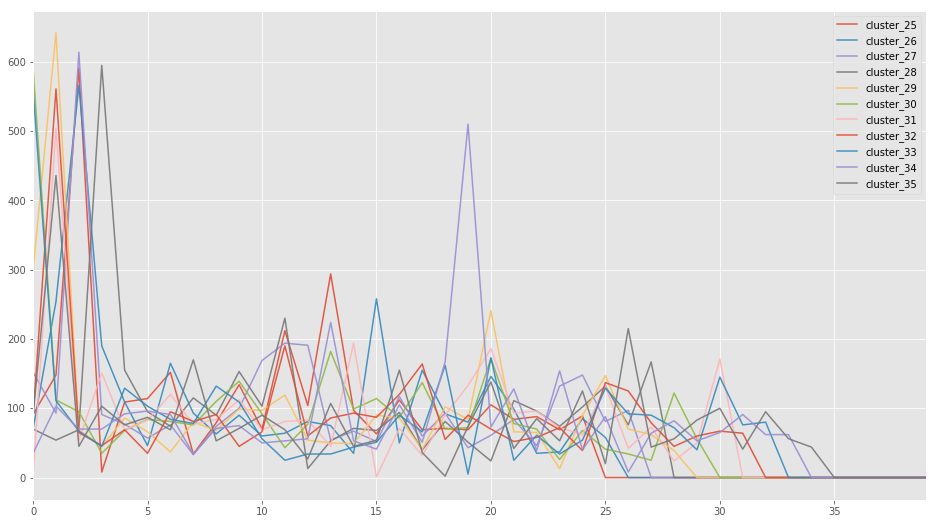

In [10]:
res_frame = ps.DataFrame()

for cluster in range(25, 36):
    ucount = text_data['cluster_by_text_' + str(cluster)].value_counts()
    cluster_count = np.zeros(40)
    for c, cnt in ucount.items():
        cluster_count[c] = cnt
    res_frame["cluster_" + str(cluster)] = cluster_count

res_frame.plot(kind="line", alpha=0.9, figsize=(16, 9))

Let suppose that we have 35 unique clusters. 

So we will take `cluster_by_text_35` column as labels.

For future let's save data to __.csv__.

In [11]:
text_data.to_csv('../data/text_data.csv', sep='|')
# tmp = ps.read_csv('../data/clustered_data.csv', sep='|')
# tmp.head()

# Classification


Firstly let's try some simple models like [Multinomial Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes) or [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(text_data.text, text_data.cluster_by_text_35,
                                                    test_size=0.3, random_state=1013)

In [13]:
# Multinomial Naive Bayes
mnb_text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('mnb-clf', MultinomialNB())])

mnb_text_clf = mnb_text_clf.fit(X_train, y_train)

In [14]:
mnb_text_clf.score(X_test, y_test)

0.31297709923664124

In [15]:
# Stochastic Gradient Descent
sgd_text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('sgd-clf', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3, 
                                                   random_state=811))])

sgd_text_clf = sgd_text_clf.fit(X_train, y_train)

/Users/ditwoo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [16]:
sgd_text_clf.score(X_test, y_test)

0.7851690294438386

# Neural networks

[Inspired by.](https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/)

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

Using TensorFlow backend.


In [18]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text_data.text.values)
sequences = tokenizer.texts_to_sequences(text_data.text.values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/Users/ditwoo/anaconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 16153 unique tokens.


In [20]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(text_data.cluster_by_text_35.values)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (3056, 1000)
Shape of label tensor: (3056, 35)


In [23]:
# shufling
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set ')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in traing and validation set 
[  69.  345.   35.   81.   54.   69.   56.  134.   42.   61.   69.   59.
   22.   85.   39.   40.  121.   33.    2.   62.  116.   38.   66.   45.
   97.   18.  177.   34.   44.   67.   78.   31.   78.   46.   32.]
[ 21.  91.  10.  22.  22.  18.  13.  36.  11.  10.  21.  10.   5.  22.   6.
  14.  34.   3.   0.  12.  22.   4.  19.   8.  28.   2.  38.  10.  12.  16.
  22.  10.  17.  10.  12.]


In [24]:
GLOVE_DIR = "../data/glove/glove.6B.100d.txt"
embeddings_index = {}
with open(GLOVE_DIR, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [25]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

![Layers](https://richliao.github.io/images/YoonKim_ConvtextClassifier.png)

In [26]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(35, activation='softmax')(l_dense)

In [27]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - simplified convolutional neural network")
model.summary()
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=40, batch_size=128)

model fitting - simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         1615400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)   

/Users/ditwoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 2445 samples, validate on 611 samples
Epoch 1/40
2445/2445 [==============================] - 52s 21ms/step - loss: 3.3436 - acc: 0.1411 - val_loss: 3.4332 - val_acc: 0.1211
Epoch 2/40
2445/2445 [==============================] - 50s 20ms/step - loss: 3.1864 - acc: 0.1583 - val_loss: 3.1455 - val_acc: 0.1669
Epoch 3/40
2445/2445 [==============================] - 50s 20ms/step - loss: 3.0637 - acc: 0.1779 - val_loss: 3.8804 - val_acc: 0.1669
Epoch 4/40
2445/2445 [==============================] - 50s 20ms/step - loss: 2.9643 - acc: 0.2143 - val_loss: 2.9869 - val_acc: 0.2062
Epoch 5/40
2445/2445 [==============================] - 50s 20ms/step - loss: 2.7439 - acc: 0.2528 - val_loss: 2.7245 - val_acc: 0.2668
Epoch 6/40
2445/2445 [==============================] - 50s 20ms/step - loss: 2.4856 - acc: 0.3047 - val_loss: 2.6784 - val_acc: 0.2717
Epoch 7/40
2445/2445 [==============================] - 50s 20ms/step - loss: 2.3326 - acc: 0.3403 - val_loss: 2.6095 - val_acc: 0.2831
E

In [28]:
model.save('../models/simple-conv.h5')